# 주요 라이브러리 버전을 확인

In [1]:
!pip install summa

In [2]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd
import nltk
nltk.download('stopwords')
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


3.6.5
2.6.0
1.3.3
1.2.0


# Step 1. 데이터 수집하기

In [3]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [4]:
data.sample(10)

,headlines,text
25646,Warren Buffett donates $3.4 billion to charities,Warren Buffett has donated around $3.4 billion...
382,Ex-Karnataka CM snatches woman's mic at public...,"In a video that has gone viral, former Karnata..."
68758,Major bus stations to have breastfeeding rooms...,The Bangalore Metropolitan Transport Corporati...
76838,India to witness partial lunar eclipse on Augu...,"A lunar eclipse will occur on August 7 night, ..."
57210,EVMs rigged via Bluetooth: Congress Gujarat ca...,"Arjun Modhwadia, Congress' nominee from the Po..."
35503,Food regulatory body proposes colour coding un...,The Food Safety and Standards Authority of Ind...
62081,Snap loses nearly $40 million on unsold camera...,"US-based Snap, maker of photo-sharing app Snap..."
11201,Nigerian Army cites Trump to justify shooting ...,The Nigerian Army tweeted a video of US Presid...
32102,Centre in sheer contempt: SC on Cauvery water ...,The Supreme Court on Tuesday said the Centre i...
19392,Federer slams umpire for giving 'pep talk' to ...,Twenty-time Grand Slam champion Roger Federer ...


# Step 2. 데이터 전처리하기 (추상적 요약)
#### 실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

### 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [5]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [6]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('text 전체 샘플수 :', (len(data)))
data.drop_duplicates(subset = ['headlines'], inplace=True)
print('headlines 전체 샘플수 :', (len(data)))

text 전체 샘플수 : 98360
headlines 전체 샘플수 : 98262


In [7]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [8]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98262


### 텍스트 정규화와 불용어 제거

In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [10]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [11]:
# 데이터 전처리 함수 - 추상적 요약(정규화, 불필요한 정보 제거)
def preprocess_sentence(sentence, remove_stopwords=True):
    if sentence is None:  # None 값 처리
        return ''
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    return sentence  # 전처리된 문장을 반환

# 본문(text)에 대해서는 불용어 제거 적용
data['text'] = data['text'].apply(lambda x: preprocess_sentence(x, remove_stopwords=True))

# 요약(headlines)에 대해서는 불용어 제거 미적용
data['headlines'] = data['headlines'].apply(lambda x: preprocess_sentence(x, remove_stopwords=False))

# 데이터 전처리 결과 확인
data.head()


,headlines,text
0,upgrad learner switches to career in ml al w...,saurav kant an alumnus of upgrad and iiit b p...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform ...
2,new zealand end rohit sharma led india matc...,new zealand defeated india by wickets in the...
3,aegon life iterm insurance plan helps customer...,with aegon life iterm insurance plan customer...
4,have known hirani for yrs what if metoo claim...,speaking about the sexual harassment allegatio...


In [12]:
clean_text = []

for text in data['text']:
    processed_text = preprocess_sentence(text)
    clean_text.append(processed_text)


# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant  an alumnus of upgrad and iiit b pg program in machine learning and artificial intelligence  was a sr systems engineer at infosys with almost   years of work experience  the program and upgrad     degree career support helped him transition to a data scientist at tech mahindra with     salary hike  upgrad online power learning has powered   lakh  careers ', 'kunal shah credit card bill payment platform  cred  gave users a chance to win free food from swiggy for one year  pranav kaushik  a delhi techie  bagged this reward after spending      cred coins  users get one cred coin per rupee of bill paid  which can be used to avail rewards from brands like ixigo  bookmyshow  ubereats  cult fit and more ', 'new zealand defeated india by   wickets in the fourth odi at hamilton on thursday to win their first match of the five match odi series  india lost an international match under rohit sharma captaincy after    consecutive victories dating back to march       th

In [13]:
clean_headlines = []

for headlines in data['headlines']:
    processed_headlines = preprocess_sentence(headlines)
    clean_headlines.append(processed_headlines)


# 전처리 후 출력
print("Headlines 전처리 후 결과: ", clean_headlines[:5])

Headlines 전처리 후 결과:  ['upgrad learner switches to career in ml   al with     salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india    match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs  what if metoo claims are not true  sonam']


In [14]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [15]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [16]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98262


### Train, Test 데이터 나누기 - 샘플의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 71
텍스트의 평균 길이 : 57.92975921515947
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 17
헤드라인의 평균 길이 : 9.48376788585618


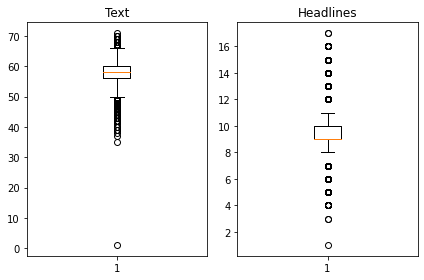

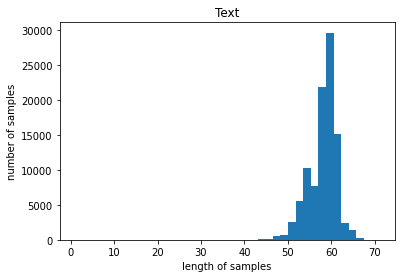

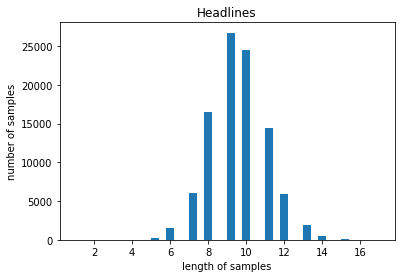

In [17]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [18]:
text_max_len = 60
headlines_max_len = 15

In [19]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [20]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 0.8045124259632411
전체 샘플 중 길이가 15 이하인 샘플의 비율: 0.9998066393926441


In [21]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 79043


#### 시작 토큰과 종료 토큰 추가하기

In [22]:
# 제목 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al w...,saurav kant an alumnus of upgrad and iiit b p...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al w...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform ...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india matc...,new zealand defeated india by wickets in the...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india matc...
3,aegon life iterm insurance plan helps customer...,with aegon life iterm insurance plan customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan has deni...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


In [23]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [24]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[55819 12748  7389 ... 68902 78911  5568]


In [25]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [26]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 15808


In [27]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 63235
훈련 레이블의 개수 : 63235
테스트 데이터의 개수 : 15808
테스트 레이블의 개수 : 15808


### 단어 집합(vocabulary) 만들기 및 정수 인코딩

In [28]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [29]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 63860
등장 빈도가 6번 이하인 희귀 단어의 수: 43789
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20071
단어 집합에서 희귀 단어의 비율: 68.57031005324147
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.476626215660193


In [30]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [31]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[1, 4050, 2438, 3, 5884, 205, 5360, 1434, 40, 76, 12, 4676, 6, 6918, 14, 2405, 7796, 47, 1, 236, 150, 319, 470, 1, 871, 6529, 36, 1, 500, 5884, 48, 4051, 2998, 1354, 74, 177, 1034, 5, 1, 6, 15, 10, 5, 1, 4581], [274, 92, 3371, 4025, 8, 1923, 2, 333, 35, 259, 202, 1261, 87, 3, 681, 109, 1, 80, 415, 846, 3, 64, 1, 21, 25, 7, 370, 5, 898, 1462, 6, 6343, 242, 70, 2, 87, 29, 13, 429, 5474, 5, 3371, 21, 194, 70, 1, 271, 3, 395], [1, 245, 62, 7, 118, 11, 1, 410, 6628, 442, 209, 7, 545, 303, 4114, 2308, 12, 3723, 219, 72, 456, 77, 25, 1763, 1, 2449, 62, 39, 11, 2308, 172, 25, 343, 1, 209, 7, 573, 46, 68, 1213, 2308, 887, 14, 116, 2308, 27, 1250, 1, 1634, 2386, 1, 44, 373, 392, 2, 1342, 68, 7, 774]]


In [32]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [33]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 27821
등장 빈도가 5번 이하인 희귀 단어의 수: 18579
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9242
단어 집합에서 희귀 단어의 비율: 66.78048955824737
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.375351080718036


In [34]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 1020, 1010, 958], [1, 35, 76, 6, 81, 3, 74, 39, 92, 896, 536], [1, 48, 1113, 3, 243, 90, 1724, 64, 318], [1, 35, 1999, 5], [1, 87, 42, 165, 93, 4, 28, 371]]
target
decoder  [[1020, 1010, 958, 2], [35, 76, 6, 81, 3, 74, 39, 92, 896, 536, 2], [48, 1113, 3, 243, 90, 1724, 64, 318, 2], [35, 1999, 5, 2], [87, 42, 165, 93, 4, 28, 371, 2]]


In [35]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 10
삭제할 테스트 데이터의 개수 : 3
훈련 데이터의 개수 : 63225
훈련 레이블의 개수 : 63225
테스트 데이터의 개수 : 15805
테스트 레이블의 개수 : 15805


### 패딩하기

In [36]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

# Step 3. 어텐션 메커니즘 사용하기

In [37]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

In [38]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [39]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [40]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 모델 훈련하기

In [41]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
247/247 [==============================] - 32s 99ms/step - loss: 3.2289 - val_loss: 2.9923
Epoch 2/50
247/247 [==============================] - 24s 96ms/step - loss: 2.8811 - val_loss: 2.7446
Epoch 3/50
247/247 [==============================] - 24s 98ms/step - loss: 2.6468 - val_loss: 2.5804
Epoch 4/50
247/247 [==============================] - 24s 97ms/step - loss: 2.4739 - val_loss: 2.4279
Epoch 5/50
247/247 [==============================] - 24s 97ms/step - loss: 2.3451 - val_loss: 2.3309
Epoch 6/50
247/247 [==============================] - 24s 99ms/step - loss: 2.2430 - val_loss: 2.2551
Epoch 7/50
247/247 [==============================] - 25s 100ms/step - loss: 2.1570 - val_loss: 2.1995
Epoch 8/50
247/247 [==============================] - 25s 101ms/step - loss: 2.0838 - val_loss: 2.1513
Epoch 9/50
247/247 [==============================] - 25s 100ms/step - loss: 2.0199 - val_loss: 2.1156
Epoch 10/50
247/247 [==============================] - 25s 100ms/step - loss: 1

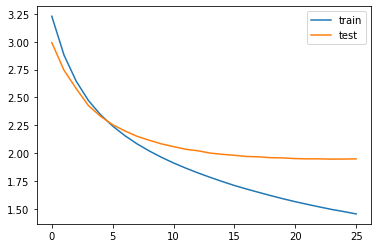

In [42]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 인퍼런스 모델 구현하기

In [43]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [44]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [45]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [46]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

# Step 4. 실제 결과와 요약문 비교하기

In [47]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

def seq2summary(input_seq):
    sostoken_idx = tar_word_to_index['sostoken']  # 예시로 설정한 sostoken의 인덱스 값
    eostoken_idx = tar_word_to_index['eostoken']  # 예시로 설정한 eostoken의 인덱스 값
    
    temp = ''
    for i in input_seq:
        if (i != 0) and (i != sostoken_idx) and (i != eostoken_idx):
            temp = temp + tar_index_to_word[i] + ' '
    return temp.strip()

In [48]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : vice president venkaiah naidu has said the billion pnb scam brought bad name to the system and is an eye opener for everyone he also emphasised the need for greater transparency and corporate governance earlier he said only two three instances of nirav modi choksi and vijay mallya but they are damaging the image of the country 
실제 요약 : pnb scam bad name an vice prez naidu
예측 요약 :  you are to be to make a choksi vp


원문 : russia ambassador to said any us missiles fired at syria would be shot down and their launch sites will be targeted us president donald trump had vowed to respond to an alleged chemical attack by syria government a russian ally within hours the us had fired missiles at a syrian after a similar attack last year 
실제 요약 : us fired at syria will be shot down russia
예측 요약 :  russia russia syria syria syria


원문 : the champagne gold train on its maiden journey from tokyo on may the car train passengers in with prices reaching up to per person operated by the east japan 

# Step 5. Summa를 이용해서 추출적 요약해보기

In [59]:
from transformers import pipeline

# 요약 파이프라인 생성
summarizer = pipeline("summarization")

# 요약 실행
summary = summarizer(text, max_length=50, min_length=25, do_sample=False)

print('Summary:')
print(summary[0]['summary_text'])

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)


Summary:
 madhesi morcha  an alliance of seven political parties has withdrawn support to pm pushpa kamal dahal led nepal government . The morcha has seats in the parliament but there is no immediate threat to the government


In [61]:
import pandas as pd
from transformers import pipeline

# 데이터 읽기
data1 = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data1_text = data1['text'].iloc[i]

# 요약 파이프라인 생성
summarizer = pipeline("summarization")

# 요약 실행 (ratio 대신 max_length와 min_length로 설정)
summary = summarizer(data1_text, max_length=100, min_length=30, do_sample=False)

# 결과 출력
print('Summary:')
print(summary[0]['summary_text'])

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)
Your max_length is set to 100, but you input_length is only 83. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Summary:
 Prime Minister Narendra Modi said demonetisation and RERA have put a check on black money that used to be "parked in the real estate sector" He said 'UDAN' scheme has boosted the development of the country's aviation sector .


In [65]:
import nltk
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer

# NLTK punkt 다운로드
nltk.download('punkt')

# 텍스트 추출
data1_text = data1['text'].iloc[0]

# 텍스트 파서와 토크나이저 생성
parser = PlaintextParser.from_string(data1_text, Tokenizer("english"))
summarizer = LsaSummarizer()

# 요약 실행 (5 문장으로 요약)
summary = summarizer(parser.document, 5)

# 결과 출력
print("Summary:")
for sentence in summary:
    print(sentence)

[nltk_data] Downloading package punkt to /aiffel/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Summary:
Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience.
The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.
upGrad's Online Power Learning has powered 3 lakh+ careers.


In [66]:
from summa.summarizer import summarize

# 모델 요약과 Summa 요약을 비교
for i in range(50, 100):
    # 모델을 사용한 요약 생성
    original_text = seq2text(encoder_input_test[i])
    actual_summary = seq2summary(decoder_input_test[i])
    predicted_summary = decode_sequence(encoder_input_test[i].reshape(1, text_max_len))
    
    # Summa를 사용한 요약 생성
    summa_summary = ""
    data1_text = data1['text'].iloc[i]  
    if len(data1_text.split()) > 50:  # 원문이 충분히 길 경우에만 요약 시도
        summa_summary = summarize(data1_text, ratio = 0.6)  
    
    if not summa_summary.strip():
        summa_summary = "Summa 요약이 생성되지 않았습니다."
    
    # 결과 출력
    print(f"원문 [{i}]:", original_text)
    print(f"실제 요약 [{i}]:", actual_summary)
    print(f"모델 예측 요약 [{i}]:", predicted_summary)
    print(f"Summa 요약 [{i}]:", summa_summary)
    print("\n" + "="*100 + "\n")

원문 [50]: vice president venkaiah naidu has said the billion pnb scam brought bad name to the system and is an eye opener for everyone he also emphasised the need for greater transparency and corporate governance earlier he said only two three instances of nirav modi choksi and vijay mallya but they are damaging the image of the country 
실제 요약 [50]: pnb scam bad name an vice prez naidu
모델 예측 요약 [50]:  you are to be to make a choksi vp
Summa 요약 [50]: Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).


원문 [51]: russia ambassador to said any us missiles fired at syria would be shot down and their launch sites will be targeted us president donald trump had vowed to respond to an alleged chemical attack by syria government a russian ally within hours the us had fired missiles at a syrian after a similar attack last year 
실제 요약 [51]: us fired at syria will be shot down russia
모델 예측 요

In [67]:
seq2text(encoder_input_test[50])

'vice president venkaiah naidu has said the billion pnb scam brought bad name to the system and is an eye opener for everyone he also emphasised the need for greater transparency and corporate governance earlier he said only two three instances of nirav modi choksi and vijay mallya but they are damaging the image of the country '

In [68]:
data1.iloc[50]

headlines    Yashwant Sinha demands probe into alleged fund...
text         Former Finance Minister Yashwant Sinha on Tues...
Name: 50, dtype: object